## 1. Giriş ve Problem Tanımı

Bu projede kullanılan veri seti, Portekizli bir bankanın 2008–2010 yılları arasında gerçekleştirdiği doğrudan pazarlama kampanyalarına ait müşteri verilerinden oluşmaktadır. Kampanyalar telefonla yapılan aramalarla yürütülmüş ve bir müşteriye aynı kampanya için birden fazla kez ulaşılmış olabilir.

### Amaç:
Müşterinin bir **vadeli mevduat ürününe abone olup olmayacağını (evet/hayır)** tahmin eden bir makine öğrenmesi modeli geliştirmektir.

### Veri Seti Özellikleri:
- **bank-full.csv**: 45.211 gözlem ve 17 özellik içerir. Projede bu veri seti kullanılacaktır.
- Veri kümesi zaman sıralıdır (Mayıs 2008 – Kasım 2010)
- Hedef değişken: `y` → `"yes"` (abone oldu) veya `"no"` (abone olmadı)




# Neden Bu Veri Seti?

- Gerçek dünya problemi(Bankacılık sektöründe kullanılabilir)

- Özellik Çeşitliliği(17 özellik)

- Yeterli Gözlem Sayısı(45.211)


In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_path = '../data/bank-full.csv'

df = pd.read_csv(data_path, sep=';')


df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
# 'unknown' değerlerinin kontrolü
df.apply(lambda x: (x == 'unknown').sum())


age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

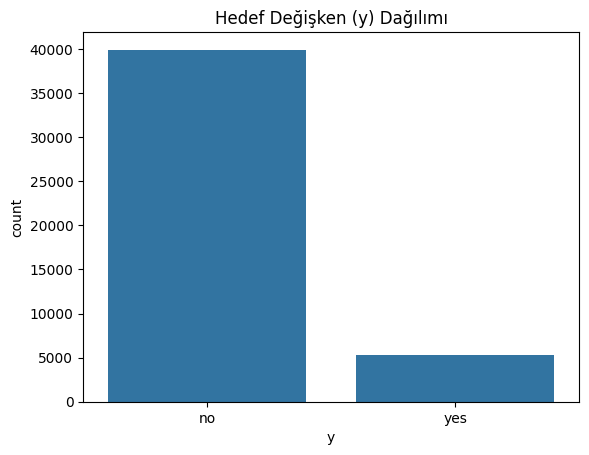

In [7]:
# Hedef değişkenin dağılımı

sns.countplot(x='y', data=df)
plt.title('Hedef Değişken (y) Dağılımı')
plt.show()

1)VERİ ÖN İŞLEME

In [8]:
print("'unknown' değerleri işleniyor...")

# job değişkeninde unknown oranı düşük olduğu için(286/45211) 'unknown' değerlerini mode ile doldurduk.
job_mode = df['job'].mode()[0]
df['job'] = df['job'].replace('unknown', job_mode)

# education için 'unknown' değerlerini 'Other' ile değiştirdik.
df['education'] = df['education'].replace('unknown', 'Other')

# contact ve poutcome için 'unknown' değerlerini 'No Info' ile değiştir
df['contact'] = df['contact'].replace('unknown', 'No Info')
df['poutcome'] = df['poutcome'].replace('unknown', 'No Info')

#education değeri bilinmezlikten uzak bir değişken olduğu için onu other olarak adlandırdık ancak contact ve poutcome değerlerinin bilinmeme durumu olabilir bu yüzden no info dedik.

print("'unknown' değerleri başarıyla işlendi.\n")



print("Veri setinin son hali:")
print(df.head())
print("\nVeri setinin boyutu:", df.shape)

'unknown' değerleri işleniyor...
'unknown' değerleri başarıyla işlendi.

Veri setinin son hali:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married      Other      no     1506     yes   no   
4   33   blue-collar   single      Other      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  No Info    5   may       261         1     -1         0  No Info  no  
1  No Info    5   may       151         1     -1         0  No Info  no  
2  No Info    5   may        76         1     -1         0  No Info  no  
3  No Info    5   may        92         1     -1         0  No Info  no  
4  No Info    5   may       198         1     -1         0  No Info  no  

Veri setinin b

Sayısal değişkenlerdeki aykırı değerler tespit ediliyor...


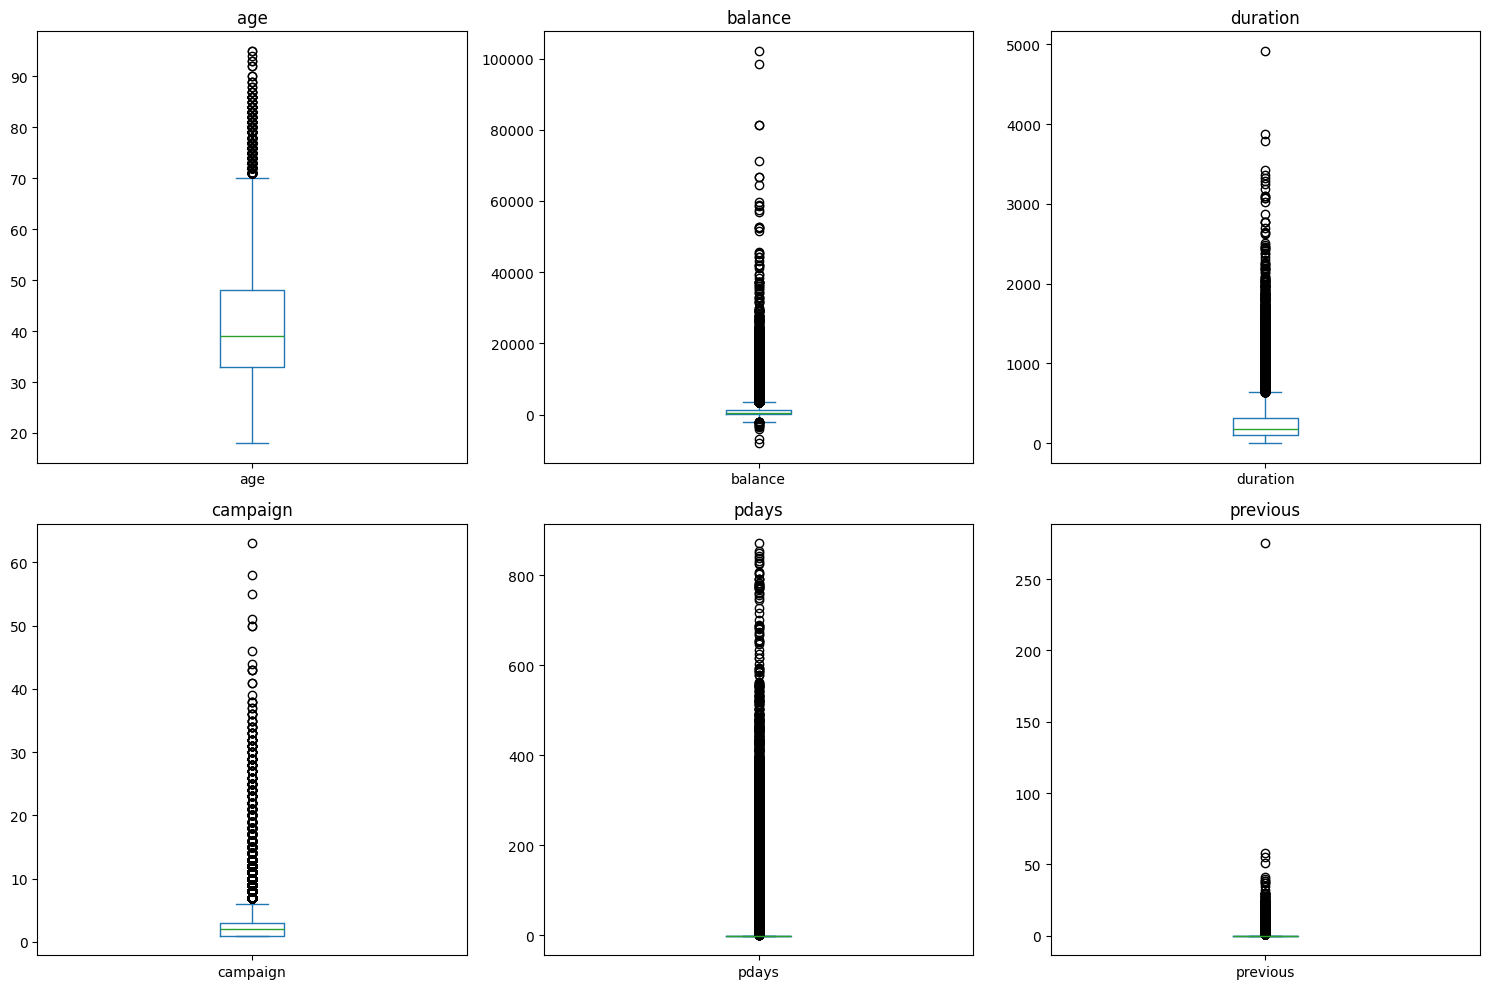


IQR yöntemi ile tespit edilen aykırı değer sayıları:
age: 487 aykırı değer
balance: 4729 aykırı değer
duration: 3235 aykırı değer
campaign: 3064 aykırı değer
pdays: 8257 aykırı değer
previous: 8257 aykırı değer


In [9]:

numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
print("Sayısal değişkenlerdeki aykırı değerler tespit ediliyor...")

# Kutu grafiği ile aykırı değerlerin görselleştirilmesi
# Her sayısal değişken için ayrı kutu grafiği
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)  # 2 satır, 3 sütunluk bir düzen (toplam 6 değişken için)
    df[col].plot(kind='box')
    plt.title(col)
plt.tight_layout()
plt.show()

# IQR yöntemi ile aykırı değer tespiti
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Her sayısal değişken için aykırı değer sayısı
print("\nIQR yöntemi ile tespit edilen aykırı değer sayıları:")
for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} aykırı değer")



In [10]:
# 1. Age - Herhangi bir dönüşüm gerekmez, olduğu gibi bırakıyoruz.
# Yaş değişkeni zaten nispeten normal dağılıma sahip ve aykırı değerler az, bu yüzden dönüşüm uygulanmadı

# 2. Balance (Bakiye) - Logaritmik dönüşüm ve kategorilendirme
# Bakiye değişkeni çok geniş bir aralığa sahip ve aykırı değerler içeriyor
# Logaritmik dönüşüm, büyük değerlerin etkisini azaltarak dağılımı normalleştirmeyi amaçlıyorum.
# Negatif değerleri pozitife çevirmek için bir offset ekliyoruz
min_balance = df['balance'].min()
if min_balance < 0:
    df['balance_log'] = np.log1p(df['balance'] - min_balance + 1)
else:
    df['balance_log'] = np.log1p(df['balance'])

# Balance için kategoriler - Kategorilendirme, sürekli değişkeni gruplara ayırarak modellemedeki etkisini daha anlamlı hale getirir
# Negatif, düşük, orta ve yüksek bakiyeler arasındaki davranış farklılıklarını yakalamak için bu aralıkları seçtim.
df['balance_cat'] = pd.cut(df['balance'], 
                          bins=[-10000, 0, 1000, 5000, 100000], 
                          labels=['Negatif', 'Düşük', 'Orta', 'Yüksek'])

# 3. Duration (Görüşme Süresi) - Logaritmik dönüşüm
# Görüşme süresi sağa çarpık bir dağılıma sahip ve aykırı değerler içeriyor
# Logaritmik dönüşüm uzun görüşmelerin etkisini azaltarak daha dengeli bir dağılım sağlar
df['duration_log'] = np.log1p(df['duration'])

# 4. Campaign (Kampanya) - Kategorilendirme
# Kampanya sayısı da sağa çarpık dağılıma sahip, çoğu müşteri az sayıda kampanyaya maruz kalırken, bazıları çok fazla
# Kategorilendirme ile farklı kampanya yoğunluklarının etkisi daha iyi modellenebilir
df['campaign_cat'] = pd.cut(df['campaign'], 
                           bins=[0, 1, 3, 10, 65], 
                           labels=['Tek', 'Az', 'Orta', 'Çok'])

# 5. Pdays (Önceki İletişimden Bu Yana Geçen Gün) - İkili dönüşüm ve özel kategori
# Pdays değişkeni -1 (daha önce iletişim kurulmamış) ve pozitif değerlerden oluşuyor
# İkili dönüşüm, müşterilerle daha önce iletişim kurulup kurulmadığını gösterir 
df['contacted_before'] = (df['pdays'] != -1).astype(int)  # 0: Hayır, 1: Evet
# Ek olarak, uzun süre önce iletişim kurulmuş müşteriler için ayrı bir kategori oluşturuyoruz
# Bu, zamanın müşteri davranışı üzerindeki etkisini yakalamak için önemli
df['pdays_long_ago'] = ((df['pdays'] > 100) & (df['pdays'] != -1)).astype(int)

# 6. Previous (Önceki Kampanya İletişim Sayısı) - Kategorilendirme
# Previous değişkeni de sağa çarpık bir dağılıma sahip ve çoğunlukla 0 değerinde yoğunlaşıyor
# Kategorilendirme ile önceki iletişim yoğunluğunun etkisi daha iyi modellenebilir
df['previous_cat'] = pd.cut(df['previous'], 
                           bins=[-1, 0, 5, 10, 300], 
                           labels=['Hiç', 'Az', 'Orta', 'Çok'])

# Uç değerleri korurken anlamlı feature'lar oluşturmak için oranlar
# Müşteri başına ortalama görüşme süresi- Bu, müşterinin ilgi düzeyini gösterebilir
df['avg_duration_per_campaign'] = df['duration'] / (df['campaign'] + 1)  # paydada sıfır olmaması için +1 ekledim.

# Önceki başarılı kampanyaların oranı - Müşterinin geçmiş kampanyalara tepkisini yansıtır
# Yüksek oran, müşterinin bankaya daha açık olduğunu gösterebilir
df['previous_success_rate'] = df['previous'] / (df['campaign'] + df['previous'] + 1)  

print("Aykırı değer dönüşümleri tamamlandı.")

# Dönüşümlerin kontrolü
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
transformed_cols = ['balance_log', 'duration_log', 'avg_duration_per_campaign', 'previous_success_rate']

# Dönüşüm sonrası özet istatistikler
print("\nDönüşüm sonrası özet istatistikler:")
print(df[transformed_cols].describe())

# Kategorik dönüşümlerin kontrolü
print("\nKategorik dönüşümlerin dağılımı:")
for col in ['balance_cat', 'campaign_cat', 'contacted_before', 'previous_cat']:
    
    print(df[col].value_counts(normalize=True) * 100)

Aykırı değer dönüşümleri tamamlandı.

Dönüşüm sonrası özet istatistikler:
        balance_log  duration_log  avg_duration_per_campaign  \
count  45211.000000  45211.000000               45211.000000   
mean       9.118780      5.171812                  91.881443   
std        0.212325      0.921822                 101.502003   
min        0.693147      0.000000                   0.000000   
25%        8.998755      4.644391                  30.500000   
50%        9.044168      5.198497                  61.333333   
75%        9.153664      5.768321                 116.500000   
max       11.609580      8.500861                2459.000000   

       previous_success_rate  
count           45211.000000  
mean                0.082619  
std                 0.189755  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 0.989209  

Kategorik dönüşümlerin dağılımı:
balance_cat
Düşük      51.537271
Ort

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        45211 non-null  int64   
 1   job                        45211 non-null  object  
 2   marital                    45211 non-null  object  
 3   education                  45211 non-null  object  
 4   default                    45211 non-null  object  
 5   balance                    45211 non-null  int64   
 6   housing                    45211 non-null  object  
 7   loan                       45211 non-null  object  
 8   contact                    45211 non-null  object  
 9   day                        45211 non-null  int64   
 10  month                      45211 non-null  object  
 11  duration                   45211 non-null  int64   
 12  campaign                   45211 non-null  int64   
 13  pdays                      4521

In [12]:
print("## Kategorik Değişkenleri Encoding ile Dönüştürme ##\n")

# Kategorik değişkenleri listeleme
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Kategorik değişkenler: {categorical_cols}")

# Poutcome kategorik değişkenini dönüştürme
print("\nPoutcome değişkenini dönüştürüyorum...")
# One-Hot Encoding öncesi poutcome değerlerini kontrol edelim
print("Poutcome değişkenindeki eşsiz değerler:", df['poutcome'].unique())


df['poutcome_success'] = (df['poutcome'] == 'success').astype(int)
df['poutcome_failure'] = (df['poutcome'] == 'failure').astype(int)
df['poutcome_no_info'] = (df['poutcome'] == 'No Info').astype(int)

print("Poutcome için yeni sütunlar oluşturuldu.")

# Contact kategorik değişkenini dönüştürme
print("\nContact değişkenini dönüştürüyorum...")
# One-Hot Encoding öncesi contact değerlerini kontrol edelim
print("Contact değişkenindeki eşsiz değerler:", df['contact'].unique())


df['contact_cellular'] = (df['contact'] == 'cellular').astype(int)
df['contact_telephone'] = (df['contact'] == 'telephone').astype(int)
df['contact_no_info'] = (df['contact'] == 'No Info').astype(int)

print("Contact için yeni sütunlar oluşturuldu.")

# Encoding sonrası kontrol
print("\nEncoding sonrası kontrol:")
print("Poutcome değişkeni için:")
print(f"poutcome_success toplamı: {df['poutcome_success'].sum()}")
print(f"poutcome_failure toplamı: {df['poutcome_failure'].sum()}")
print(f"poutcome_no_info toplamı: {df['poutcome_no_info'].sum()}")
print(f"Toplam: {df['poutcome_success'].sum() + df['poutcome_failure'].sum() + df['poutcome_no_info'].sum()}")

print("\nContact değişkeni için:")
print(f"contact_cellular toplamı: {df['contact_cellular'].sum()}")
print(f"contact_telephone toplamı: {df['contact_telephone'].sum()}")
print(f"contact_no_info toplamı: {df['contact_no_info'].sum()}")
print(f"Toplam: {df['contact_cellular'].sum() + df['contact_telephone'].sum() + df['contact_no_info'].sum()}")

## Kategorik Değişkenleri Encoding ile Dönüştürme ##

Kategorik değişkenler: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

Poutcome değişkenini dönüştürüyorum...
Poutcome değişkenindeki eşsiz değerler: ['No Info' 'failure' 'other' 'success']
Poutcome için yeni sütunlar oluşturuldu.

Contact değişkenini dönüştürüyorum...
Contact değişkenindeki eşsiz değerler: ['No Info' 'cellular' 'telephone']
Contact için yeni sütunlar oluşturuldu.

Encoding sonrası kontrol:
Poutcome değişkeni için:
poutcome_success toplamı: 1511
poutcome_failure toplamı: 4901
poutcome_no_info toplamı: 36959
Toplam: 43371

Contact değişkeni için:
contact_cellular toplamı: 29285
contact_telephone toplamı: 2906
contact_no_info toplamı: 13020
Toplam: 45211


In [13]:
# Diğer kategorik değişkenleri dönüştürme
print("\n## Diğer Kategorik Değişkenleri Dönüştürme ##\n")

# Mevcut veri setinde hala object tipinde olan kategorik değişkenler
remaining_cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Dönüştürülecek kalan kategorik değişkenler: {remaining_cat_cols}")

# 'y' değişkenini dönüştürme işleminden hariç tutalım
if 'y' in remaining_cat_cols:
    remaining_cat_cols.remove('y')
    print("'y' değişkeni hedef değişken olduğu için dönüştürülmeyecek ve orijinal haliyle korunacaktır.")

# Her bir değişken için uygun encoding yöntemini belirleme
for col in remaining_cat_cols:
    # Eşsiz değerleri kontrol et
    unique_values = df[col].unique()
    n_unique = len(unique_values)
    print(f"\n{col} değişkeni için eşsiz değerler ({n_unique}): {unique_values}")
    
    # İkili değişkenler için Label Encoding
    if n_unique == 2:
        # Target değişkeni (y) için ayrı işlem yapmıyoruz artık
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        df[col+'_encoded'] = le.fit_transform(df[col])
        
        # Hangi değerin hangi sayıya dönüştüğünü gösterelim
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"{col} için Label Encoding yapıldı. Eşleme: {mapping}")
        print(f"{col}_encoded sütunu oluşturuldu.")
    
    # Çok sayıda kategori içeren değişkenler için One-Hot Encoding
    else:
        # One-hot encoding uygula
        dummies = pd.get_dummies(df[col], prefix=col)
        
        # Orijinal veri setine ekle
        df = pd.concat([df, dummies], axis=1)
        
        print(f"{col} için One-Hot Encoding yapıldı. {dummies.shape[1]} yeni sütun oluşturuldu.")

# Kategorik sütunlar ve encoded versiyonları tamamlandıktan sonra
# Artık orijinal kategorik sütunları kaldırabiliriz ('y' hariç)
original_cat_cols_to_drop = [col for col in remaining_cat_cols] 
df = df.drop(columns=original_cat_cols_to_drop)
print(f"\n{len(original_cat_cols_to_drop)} adet orijinal kategorik sütun kaldırıldı.")
print("'y' değişkeni orijinal haliyle korundu.")

# Encoding sonrası veri seti bilgisi
print("\nEncoding sonrası veri seti boyutu:", df.shape)
print("Encoding sonrası toplam sütun sayısı:", len(df.columns))

# One-hot encoding sonrası ilk birkaç satır
print("\nVeri setinin ilk 5 satırı:")
print(df.head())

# Dönüştürülen değişkenlerin kontrolü
print("\nDönüştürülen değişkenlerin veri tipleri:")
print(df.dtypes)


## Diğer Kategorik Değişkenleri Dönüştürme ##

Dönüştürülecek kalan kategorik değişkenler: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
'y' değişkeni hedef değişken olduğu için dönüştürülmeyecek ve orijinal haliyle korunacaktır.

job değişkeni için eşsiz değerler (11): ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
job için One-Hot Encoding yapıldı. 11 yeni sütun oluşturuldu.

marital değişkeni için eşsiz değerler (3): ['married' 'single' 'divorced']
marital için One-Hot Encoding yapıldı. 3 yeni sütun oluşturuldu.

education değişkeni için eşsiz değerler (4): ['tertiary' 'secondary' 'Other' 'primary']
education için One-Hot Encoding yapıldı. 4 yeni sütun oluşturuldu.

default değişkeni için eşsiz değerler (2): ['no' 'yes']
default için Label Encoding yapıldı. Eşleme: {'no': np.int64(0), 'yes': np.int64(1)}
default_encoded sütunu oluşturuldu.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        45211 non-null  int64   
 1   balance                    45211 non-null  int64   
 2   day                        45211 non-null  int64   
 3   duration                   45211 non-null  int64   
 4   campaign                   45211 non-null  int64   
 5   pdays                      45211 non-null  int64   
 6   previous                   45211 non-null  int64   
 7   y                          45211 non-null  object  
 8   balance_log                45211 non-null  float64 
 9   balance_cat                45210 non-null  category
 10  duration_log               45211 non-null  float64 
 11  campaign_cat               45211 non-null  category
 12  contacted_before           45211 non-null  int64   
 13  pdays_long_ago             4521

In [14]:
#Veri setini incelediğimde çift sütunlar olduğunu gördüm.
print("Çift sütunlar:")
duplicate_columns = df.columns[df.columns.duplicated()].tolist()
print(duplicate_columns)

# Çift sütunları kaldıralım (ilk oluşturulan sütunları tutarak)
df = df.loc[:, ~df.columns.duplicated(keep='first')]
print(f"Çift sütunlar kaldırıldı. Yeni sütun sayısı: {len(df.columns)}")

Çift sütunlar:
['contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_success']
Çift sütunlar kaldırıldı. Yeni sütun sayısı: 59


2.ÖZELLİK SEÇİMİ

VERİ NORMALİZASYONU

In [15]:
# Normalizasyon için değişkenleri tipine göre gruplayalım
# Sayısal değişkenler (int64, float64) normalizasyon işlemlerine tabi tutulmalı
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Boolean değişkenler (bool) zaten 0-1 formatında olduğu için işlem gerekmez
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
# Kategorik değişkenler (category ve object) normalizasyon işlemlerine tabi tutulmaz
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Hedef değişkeni çıkaralım (normalizasyon uygulanmayacak)
if 'y' in cat_cols:
    cat_cols.remove('y')
if 'y' in numeric_cols:
    numeric_cols.remove('y')

print(f"Normalize edilecek sayısal değişken sayısı: {len(numeric_cols)}")
print(f"İşlem gerektirmeyen boolean değişken sayısı: {len(bool_cols)}")
print(f"İşlem gerektirmeyen kategorik değişken sayısı: {len(cat_cols)}")

# Sayısal değişkenleri normalize etmek için uygun yöntemleri belirleyelim
# Normalizasyon öncesi özet istatistikleri görüntüleyelim
print("\nNormalizasyon öncesi sayısal değişkenlerin özet istatistikleri:")
print(df[numeric_cols].describe().T[['min', 'max', 'mean', 'std']])


Normalize edilecek sayısal değişken sayısı: 22
İşlem gerektirmeyen boolean değişken sayısı: 33
İşlem gerektirmeyen kategorik değişken sayısı: 3

Normalizasyon öncesi sayısal değişkenlerin özet istatistikleri:
                                   min            max         mean  \
age                          18.000000      95.000000    40.936210   
balance                   -8019.000000  102127.000000  1362.272058   
day                           1.000000      31.000000    15.806419   
duration                      0.000000    4918.000000   258.163080   
campaign                      1.000000      63.000000     2.763841   
pdays                        -1.000000     871.000000    40.197828   
previous                      0.000000     275.000000     0.580323   
balance_log                   0.693147      11.609580     9.118780   
duration_log                  0.000000       8.500861     5.171812   
contacted_before              0.000000       1.000000     0.182633   
pdays_long_ago       

In [16]:
print("## Gereksiz Orijinal Değişkenleri Çıkarma ##\n")


variables_to_remove = [
    'balance',  # balance_log var
    'duration',  # duration_log var
    'pdays',    # contacted_before var
    'previous'  # previous_cat var
]


df = df.drop(columns=variables_to_remove)
print(f"Aşağıdaki {len(variables_to_remove)} değişken veri setinden çıkarıldı:")
for var in variables_to_remove:
    print(f"- {var} (dönüştürülmüş versiyonu var)")


print(f"\nVeri seti boyutu: {df.shape}")

## Gereksiz Orijinal Değişkenleri Çıkarma ##

Aşağıdaki 4 değişken veri setinden çıkarıldı:
- balance (dönüştürülmüş versiyonu var)
- duration (dönüştürülmüş versiyonu var)
- pdays (dönüştürülmüş versiyonu var)
- previous (dönüştürülmüş versiyonu var)

Veri seti boyutu: (45211, 55)


Normalize edilecek güncellenmiş sayısal değişken sayısı: 18
Normalize edilecek değişkenler: ['age', 'day', 'campaign', 'balance_log', 'duration_log', 'contacted_before', 'pdays_long_ago', 'avg_duration_per_campaign', 'previous_success_rate', 'poutcome_success', 'poutcome_failure', 'poutcome_no_info', 'contact_cellular', 'contact_telephone', 'contact_no_info', 'default_encoded', 'housing_encoded', 'loan_encoded']


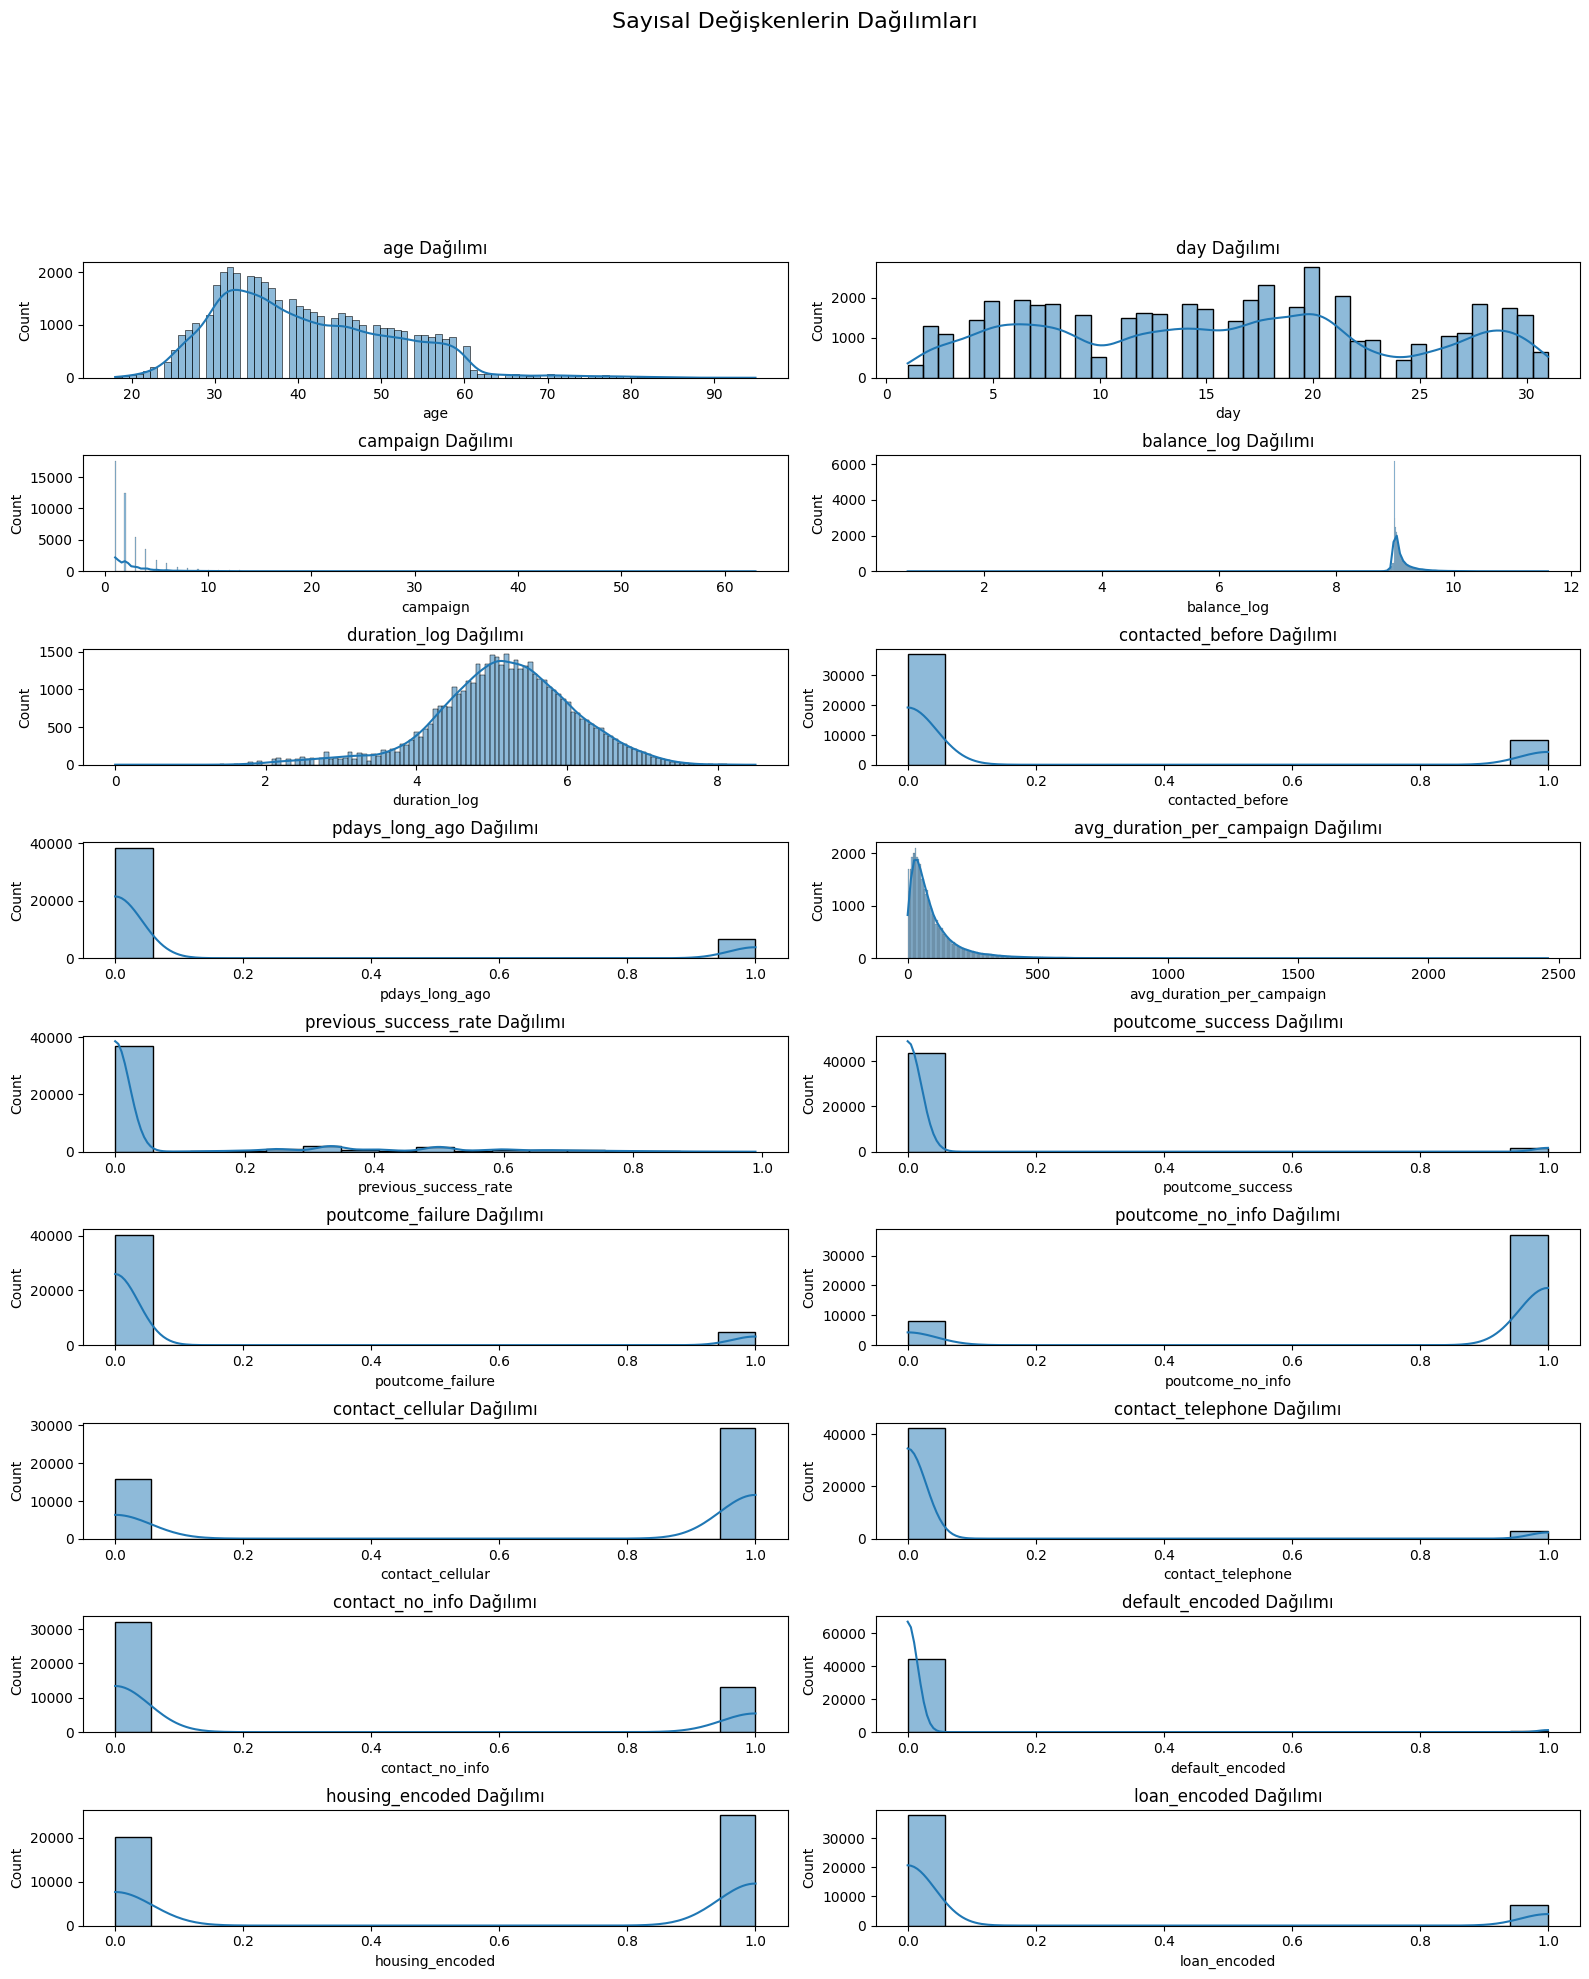


MinMaxScaler ile normalizasyon uygulanıyor...

Normalizasyon sonrası sayısal değişkenlerin özet istatistikleri:
                           min  max      mean       std
age                        0.0  1.0  0.297873  0.137906
day                        0.0  1.0  0.493547  0.277416
campaign                   0.0  1.0  0.028449  0.049968
balance_log                0.0  1.0  0.771830  0.019450
duration_log               0.0  1.0  0.608387  0.108439
contacted_before           0.0  1.0  0.182633  0.386369
pdays_long_ago             0.0  1.0  0.150848  0.357905
avg_duration_per_campaign  0.0  1.0  0.037365  0.041278
previous_success_rate      0.0  1.0  0.083521  0.191825
poutcome_success           0.0  1.0  0.033421  0.179735
poutcome_failure           0.0  1.0  0.108403  0.310892
poutcome_no_info           0.0  1.0  0.817478  0.386278
contact_cellular           0.0  1.0  0.647741  0.477680
contact_telephone          0.0  1.0  0.064276  0.245247
contact_no_info            0.0  1.0  0.287983  

In [17]:
# Şimdi sayısal değişkenleri tekrar belirleyelim (çıkarılan değişkenler sonrası)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Hedef değişkeni normalizasyon dışında tutalım
if 'y' in numeric_cols:
    numeric_cols.remove('y')

print(f"Normalize edilecek güncellenmiş sayısal değişken sayısı: {len(numeric_cols)}")
print("Normalize edilecek değişkenler:", numeric_cols)




# Sayısal değişkenlerin histogramlarını çizelim
num_plots = min(len(numeric_cols), 20)  # En fazla 20 değişken gösterelim
plt.figure(figsize=(16, num_plots * 2))

for i, col in enumerate(numeric_cols[:num_plots]):
    plt.subplot(num_plots, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Dağılımı')
    plt.tight_layout()

plt.suptitle('Sayısal Değişkenlerin Dağılımları', y=1.02, fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# MinMaxScaler kullanarak güncellenmiş sayısal değişkenleri normalize edelim
print("\nMinMaxScaler ile normalizasyon uygulanıyor...")
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = mm_scaler.fit_transform(df[numeric_cols])

# Normalizasyon sonrası özet istatistikleri görüntüleyelim
print("\nNormalizasyon sonrası sayısal değişkenlerin özet istatistikleri:")
print(df_normalized[numeric_cols].describe().T[['min', 'max', 'mean', 'std']])

# Boolean değişkenlere işlem uygulanmayacak
print("\nBoolean değişkenleri olduğu gibi bırakıyoruz (zaten 0-1 formatında).")



print("\nKategorik değişkenler zaten dönüştürülmüş durumda, ek işlem yapılmıyor.")


print("\nNormalize edilmiş veri setinin ilk 5 satırı:")
print(df_normalized.head())


print(f"\nNormalize edilmiş veri seti boyutu: {df_normalized.shape}")

print("\nNormalize edilmiş veri setinin veri tipleri:")
print(df_normalized.dtypes.value_counts())


df = df_normalized.copy()
print("\nVeri normalizasyonu tamamlandı.")

In [18]:

if 'y' in df.columns:
    # Kategorik hedef değişkeni (y) sayısal formata dönüştürelim
    le = LabelEncoder()
    y = le.fit_transform(df['y'])
    X = df.drop(columns=['y'])
    
    
    print("Hedef değişken etiketleri:")
    for cls, lbl in zip(le.classes_, range(len(le.classes_))):
        print(f"  {cls} -> {lbl}")
else:
    raise ValueError("Hedef değişken (y) bulunamadı!")

print(f"Orijinal veri seti boyutu: {X.shape}")

Hedef değişken etiketleri:
  no -> 0
  yes -> 1
Orijinal veri seti boyutu: (45211, 54)


In [19]:
print("\n### Veri Tipleri Kontrolü ###")
print(X.dtypes.value_counts())


### Veri Tipleri Kontrolü ###
bool        33
float64     18
category     1
category     1
category     1
Name: count, dtype: int64


In [20]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X[numeric_cols]
print(f"\nSayısal değişken sayısı: {len(numeric_cols)}")
print(f"Sayısal veri seti boyutu: {X_numeric.shape}")


Sayısal değişken sayısı: 18
Sayısal veri seti boyutu: (45211, 18)


NORMALİZE EDİLMİŞ VERİNİN ÖZELLİK SEÇİM YÖNTEMLERİNE UYGULANMASI

In [21]:
# Özellik seçim yöntemlerini sayısal veri üzerinde uygulayalım


print("Özellik Seti 1: Mutual Information...")
k_features = min(15, len(numeric_cols))  

# Ki-kare testi için tüm değerlerin pozitif olması gerekiyor
min_value = X_numeric.min().min()
if min_value < 0:
    X_shift = X_numeric - min_value + 0.01  # 0.01 ekleyerek 0 değerlerini de önlüyoruz
else:
    X_shift = X_numeric.copy()
    # 0 değerlerini 0.01 ile değiştirelim (Ki-kare için)
    X_shift = X_shift.clip(lower=0.01)

# Özellik Seti 1: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_features)
X_mi = selector_mi.fit_transform(X_numeric, y)
selected_features_mi = X_numeric.columns[selector_mi.get_support()]
print(f"Mutual Information ile seçilen {len(selected_features_mi)} özellik: {selected_features_mi.tolist()}")


print("\nÖzellik Seti 2: Ki-kare Testi...")
selector_chi2 = SelectKBest(score_func=chi2, k=k_features)
X_chi2 = selector_chi2.fit_transform(X_shift, y)
selected_features_chi2 = X_numeric.columns[selector_chi2.get_support()]
print(f"Ki-kare Testi ile seçilen {len(selected_features_chi2)} özellik: {selected_features_chi2.tolist()}")


print("\nÖzellik Seti 3: Recursive Feature Elimination (RFE)...")
estimator = DecisionTreeClassifier(random_state=42)
selector_rfe = RFE(estimator=estimator, n_features_to_select=k_features, step=1)
X_rfe = selector_rfe.fit_transform(X_numeric, y)
selected_features_rfe = X_numeric.columns[selector_rfe.support_]
print(f"RFE ile seçilen {len(selected_features_rfe)} özellik: {selected_features_rfe.tolist()}")


X_set1 = X_numeric[selected_features_mi]
X_set2 = X_numeric[selected_features_chi2]
X_set3 = X_numeric[selected_features_rfe]

print("\nÖzellik Setlerinin Boyutları:")
print(f"Özellik Seti 1 (Mutual Information): {X_set1.shape}")
print(f"Özellik Seti 2 (Ki-kare Testi): {X_set2.shape}")
print(f"Özellik Seti 3 (RFE): {X_set3.shape}")

Özellik Seti 1: Mutual Information...
Mutual Information ile seçilen 15 özellik: ['age', 'day', 'campaign', 'balance_log', 'duration_log', 'contacted_before', 'pdays_long_ago', 'avg_duration_per_campaign', 'previous_success_rate', 'poutcome_success', 'poutcome_no_info', 'contact_cellular', 'contact_no_info', 'housing_encoded', 'loan_encoded']

Özellik Seti 2: Ki-kare Testi...
Ki-kare Testi ile seçilen 15 özellik: ['day', 'campaign', 'duration_log', 'contacted_before', 'pdays_long_ago', 'avg_duration_per_campaign', 'previous_success_rate', 'poutcome_success', 'poutcome_no_info', 'contact_cellular', 'contact_telephone', 'contact_no_info', 'default_encoded', 'housing_encoded', 'loan_encoded']

Özellik Seti 3: Recursive Feature Elimination (RFE)...
RFE ile seçilen 15 özellik: ['age', 'day', 'campaign', 'balance_log', 'duration_log', 'pdays_long_ago', 'avg_duration_per_campaign', 'previous_success_rate', 'poutcome_success', 'poutcome_failure', 'poutcome_no_info', 'contact_cellular', 'contac

MODELLEME ve MODELLERİN DEĞERLENDİRİLMESİ

In [ ]:

test_size = 0.2
random_state = 42


X_train_set1, X_test_set1, y_train, y_test = train_test_split(
    X_set1, y, test_size=test_size, random_state=random_state, stratify=y
)
X_train_set2, X_test_set2, _, _ = train_test_split(
    X_set2, y, test_size=test_size, random_state=random_state, stratify=y
)
X_train_set3, X_test_set3, _, _ = train_test_split(
    X_set3, y, test_size=test_size, random_state=random_state, stratify=y
)

print(f"Eğitim seti boyutu: {X_train_set1.shape[0]} örnek")
print(f"Test seti boyutu: {X_test_set1.shape[0]} örnek")

#Dört Farklı Makine Öğrenimi Algoritması Tanımlayalım


knn = KNeighborsClassifier(n_neighbors=5)
print(f"Algoritma 1: K-Nearest Neighbors (KNN) - {knn}")


nb = GaussianNB()
print(f"Algoritma 2: Gaussian Naive Bayes - {nb}")


dt = DecisionTreeClassifier(random_state=42)
print(f"Algoritma 3: Decision Tree - {dt}")

# Ekstra Algoritma: Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
print(f"Algoritma 4: Gradient Boosting - {gb}")


print("\n### Tüm Kombinasyonlar için Modelleri Eğitme ve Değerlendirme ###\n")


results = {}

# Tüm model kombinasyonlarını bir döngüde eğitelim ve değerlendirelim
models = {
    'KNN': knn,
    'Naive Bayes': nb,
    'Decision Tree': dt,
    'Gradient Boosting': gb
}

feature_sets = {
    'Mutual Information': (X_train_set1, X_test_set1),
    'Chi-Square Test': (X_train_set2, X_test_set2),
    'RFE': (X_train_set3, X_test_set3)
}

# En iyi modeli tutacak değişkenler
best_accuracy = 0
best_f1 = 0
best_model_name_acc = ""
best_model_name_f1 = ""
best_feature_set_acc = ""
best_feature_set_f1 = ""

# Tüm metrikler için DataFrame'ler 
accuracy_df = pd.DataFrame(index=models.keys(), columns=feature_sets.keys())
precision_df = pd.DataFrame(index=models.keys(), columns=feature_sets.keys())
recall_df = pd.DataFrame(index=models.keys(), columns=feature_sets.keys())
f1_df = pd.DataFrame(index=models.keys(), columns=feature_sets.keys())

accuracy_df = accuracy_df.astype(float)
precision_df = precision_df.astype(float)
recall_df = recall_df.astype(float)
f1_df = f1_df.astype(float)


# Her model ve özellik seti kombinasyonu için
for model_name, model in models.items():
    print(f"\n{model_name} Algoritması Sonuçları:")
    
    for feature_set_name, (X_train, X_test) in feature_sets.items():
        try:
            
            model.fit(X_train, y_train)
            
            
            y_pred = model.predict(X_test)
            
            # Sınıflandırma raporunu al
            report = classification_report(y_test, y_pred, output_dict=True)
            
            
            accuracy = accuracy_score(y_test, y_pred)
           
            precision = report['weighted avg']['precision']
            recall = report['weighted avg']['recall']
            f1 = report['weighted avg']['f1-score']
            
            
            accuracy_df.loc[model_name, feature_set_name] = accuracy
            precision_df.loc[model_name, feature_set_name] = precision
            recall_df.loc[model_name, feature_set_name] = recall
            f1_df.loc[model_name, feature_set_name] = f1
            
            
            results[(model_name, feature_set_name)] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'classification_report': report
            }
            
            
            print(f"  {feature_set_name}:")
            print(f"    Doğruluk (Accuracy): {accuracy:.4f}")
            print(f"    Kesinlik (Precision): {precision:.4f}")
            print(f"    Duyarlılık (Recall): {recall:.4f}")
            print(f"    F1-Skoru: {f1:.4f}")
            
           
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_name_acc = model_name
                best_feature_set_acc = feature_set_name
                
            
            if f1 > best_f1:
                best_f1 = f1
                best_model_name_f1 = model_name
                best_feature_set_f1 = feature_set_name
                
        except Exception as e:
            print(f"  {feature_set_name} için hata: {str(e)}")


if best_model_name_acc:
    print(f"\nEn yüksek Doğruluk (Accuracy): {best_model_name_acc} algoritması {best_feature_set_acc} özellik seti ile, Değer: {best_accuracy:.4f}")
if best_model_name_f1:
    print(f"En yüksek F1-Skoru: {best_model_name_f1} algoritması {best_feature_set_f1} özellik seti ile, Değer: {best_f1:.4f}")

Eğitim seti boyutu: 36168 örnek
Test seti boyutu: 9043 örnek
Algoritma 1: K-Nearest Neighbors (KNN) - KNeighborsClassifier()
Algoritma 2: Gaussian Naive Bayes - GaussianNB()
Algoritma 3: Decision Tree - DecisionTreeClassifier(random_state=42)
Algoritma 4: Gradient Boosting - GradientBoostingClassifier(random_state=42)

### Tüm Kombinasyonlar için Modelleri Eğitme ve Değerlendirme ###


KNN Algoritması Sonuçları:
  Mutual Information:
    Doğruluk (Accuracy): 0.8922
    Kesinlik (Precision): 0.8769
    Duyarlılık (Recall): 0.8922
    F1-Skoru: 0.8814
  Chi-Square Test:
    Doğruluk (Accuracy): 0.8916
    Kesinlik (Precision): 0.8769
    Duyarlılık (Recall): 0.8916
    F1-Skoru: 0.8814
  RFE:
    Doğruluk (Accuracy): 0.8916
    Kesinlik (Precision): 0.8761
    Duyarlılık (Recall): 0.8916
    F1-Skoru: 0.8807

Naive Bayes Algoritması Sonuçları:
  Mutual Information:
    Doğruluk (Accuracy): 0.8241
    Kesinlik (Precision): 0.8597
    Duyarlılık (Recall): 0.8241
    F1-Skoru: 0.8389
  Chi-


### Karışıklık Matrislerinin Görselleştirilmesi ###



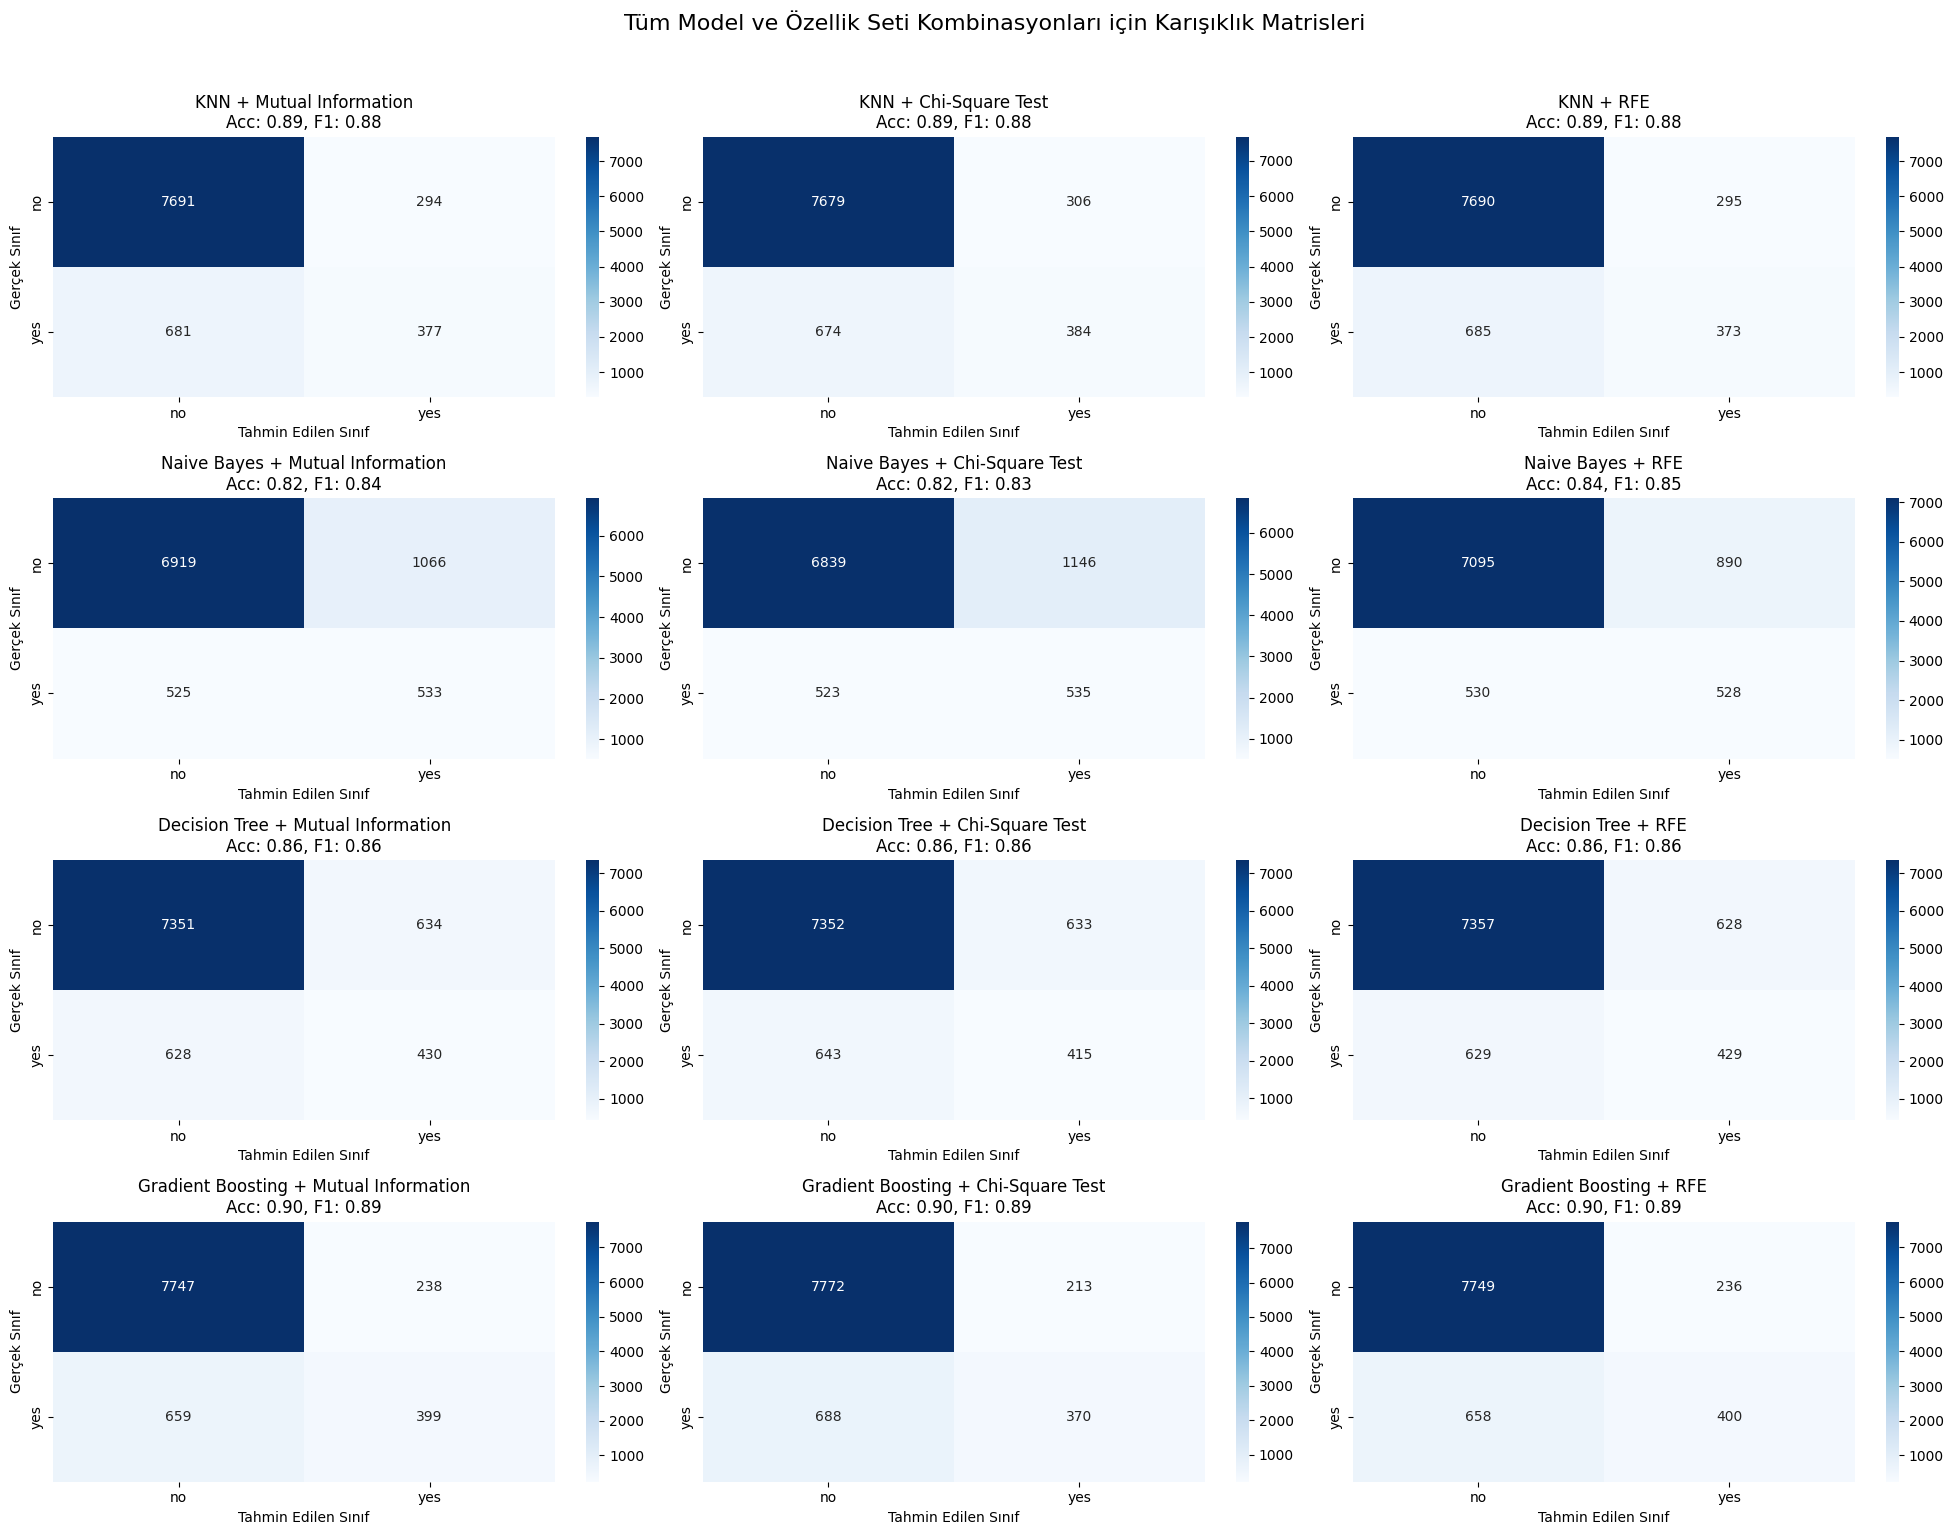

In [ ]:
# Tüm Karışıklık Matrislerini Görselleştirelim
if results:
    print("\n### Karışıklık Matrislerinin Görselleştirilmesi ###\n")

    
    plt.figure(figsize=(20, 15))
    counter = 1

    for model_name in models.keys():
        for feature_set_name in feature_sets.keys():
            if (model_name, feature_set_name) in results:
                plt.subplot(4, 3, counter)
                cm = results[(model_name, feature_set_name)]['confusion_matrix']
                
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                            xticklabels=le.classes_, yticklabels=le.classes_)
                plt.title(f"{model_name} + {feature_set_name}\nAcc: {results[(model_name, feature_set_name)]['accuracy']:.2f}, F1: {results[(model_name, feature_set_name)]['f1']:.2f}")
                plt.ylabel('Gerçek Sınıf')
                plt.xlabel('Tahmin Edilen Sınıf')
                plt.tight_layout()
                
                counter += 1

    plt.suptitle("Tüm Model ve Özellik Seti Kombinasyonları için Karışıklık Matrisleri", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


### Sonuçların Özeti - Tüm Metrikler ###

Doğruluk (Accuracy) Skorları:
                   Mutual Information  Chi-Square Test       RFE
KNN                          0.892182         0.891629  0.891629
Naive Bayes                  0.824063         0.815437  0.842972
Decision Tree                0.860445         0.858896  0.860997
Gradient Boosting            0.900807         0.900365  0.901139

Kesinlik (Precision) Skorları:
                   Mutual Information  Chi-Square Test       RFE
KNN                          0.876912         0.876865  0.876111
Naive Bayes                  0.859727         0.857510  0.865192
Decision Tree                0.860788         0.858317  0.860940
Gradient Boosting            0.887063         0.885446  0.887475

Duyarlılık (Recall) Skorları:
                   Mutual Information  Chi-Square Test       RFE
KNN                          0.892182         0.891629  0.891629
Naive Bayes                  0.824063         0.815437  0.842972
Decision Tree      

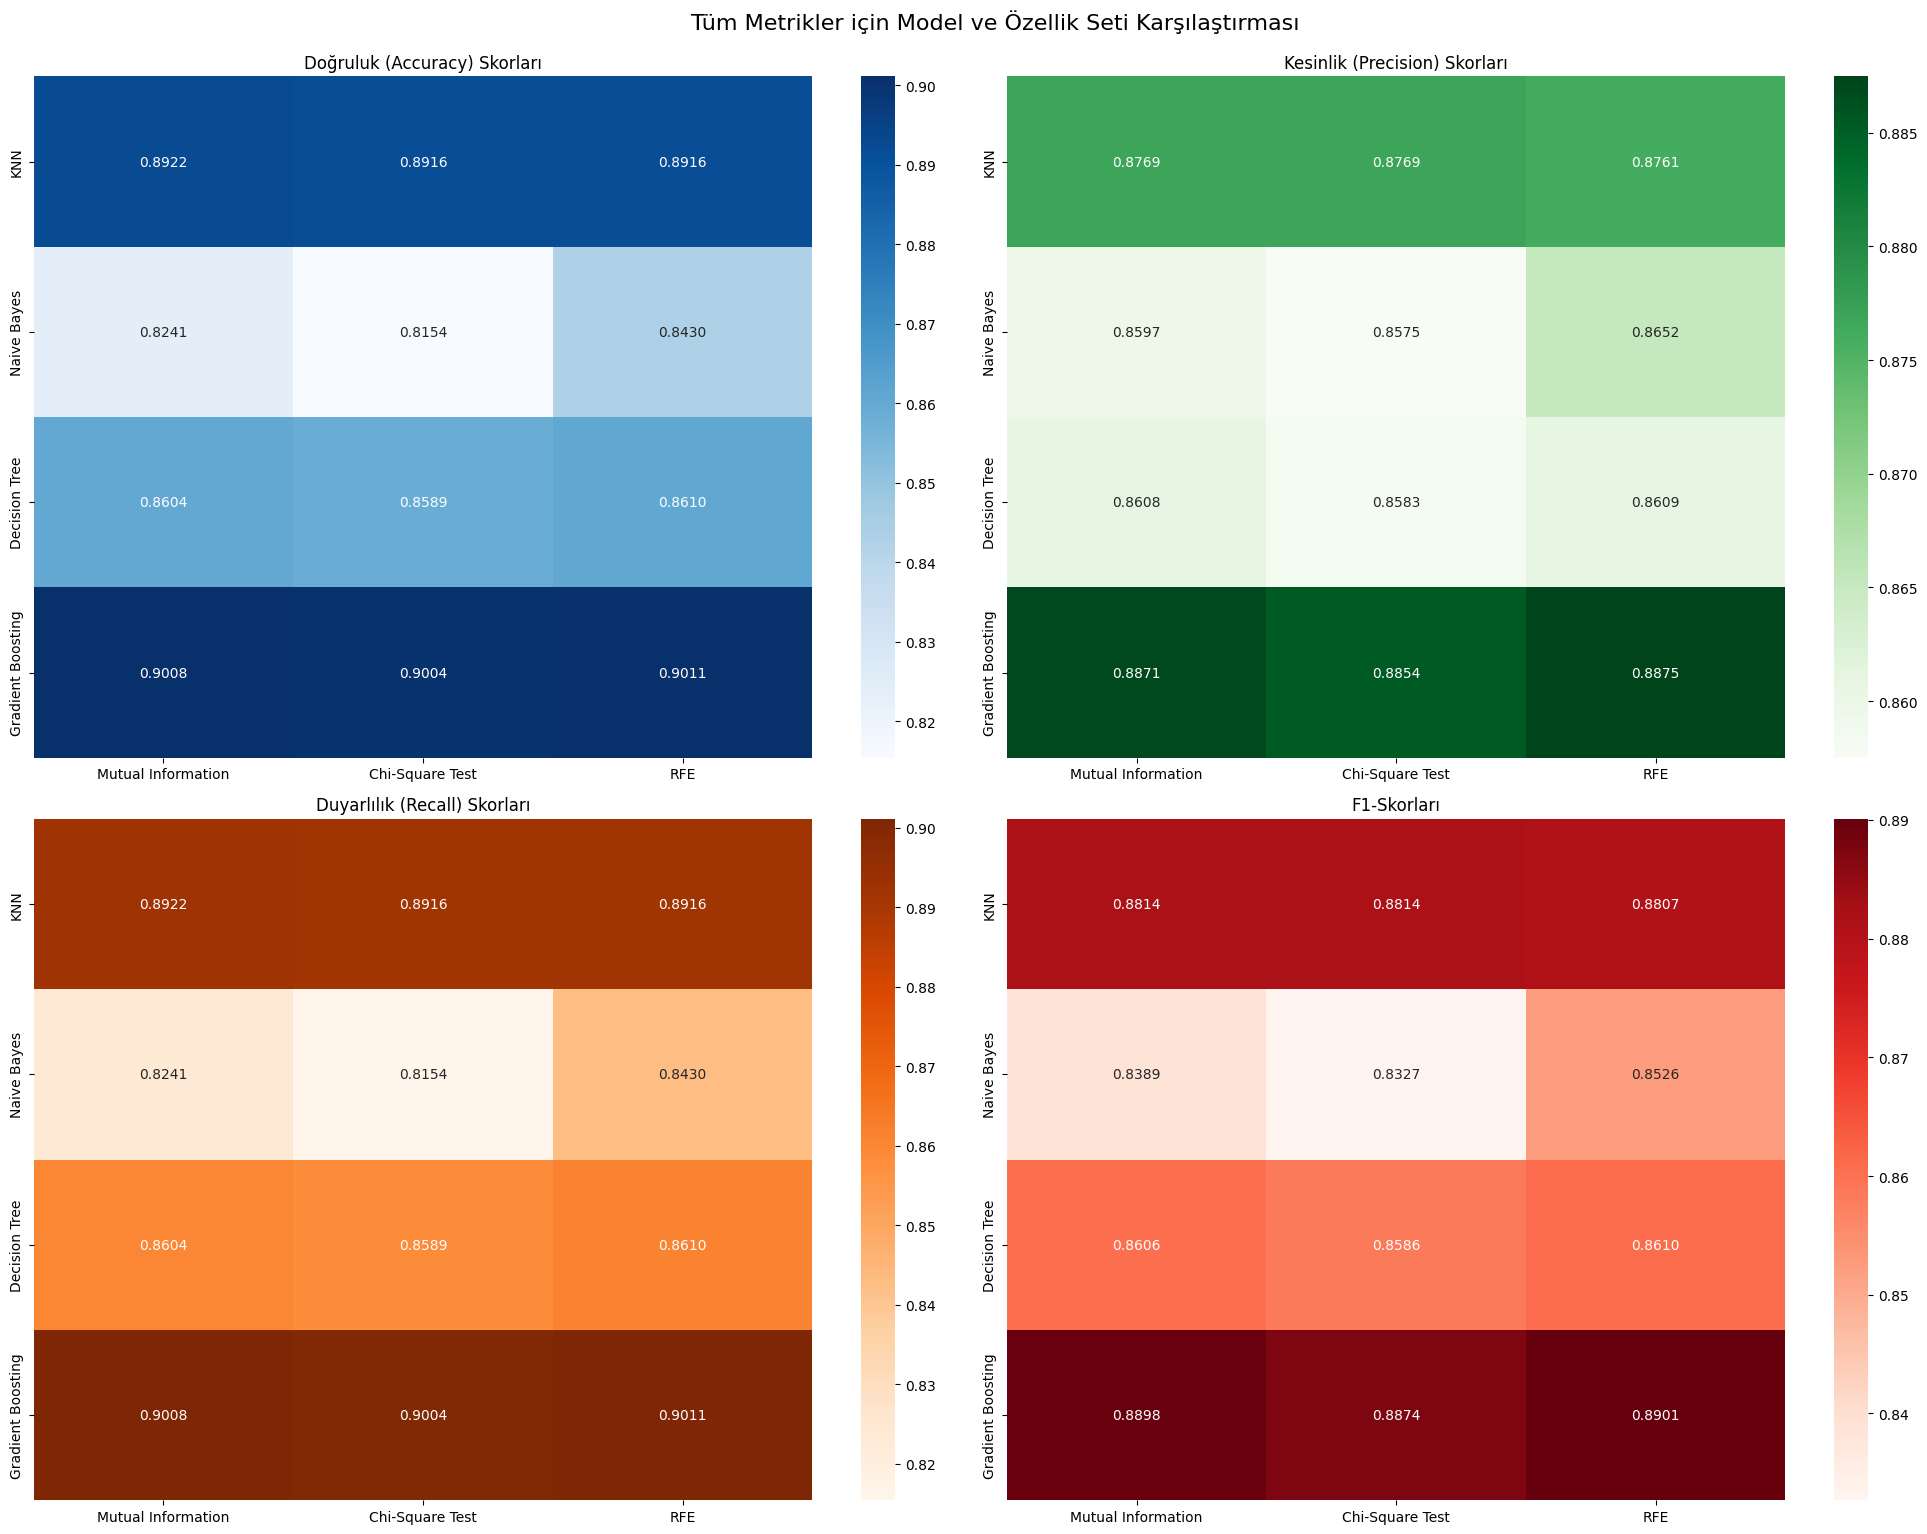

In [24]:

    print("\n### Sonuçların Özeti - Tüm Metrikler ###\n")


    print("Doğruluk (Accuracy) Skorları:")
    print(accuracy_df)
    
    print("\nKesinlik (Precision) Skorları:")
    print(precision_df)
    
    print("\nDuyarlılık (Recall) Skorları:")
    print(recall_df)
    
    print("\nF1-Skorları:")
    print(f1_df)

    
    plt.figure(figsize=(20, 15))
    
   
    plt.subplot(2, 2, 1)
    sns.heatmap(accuracy_df, annot=True, cmap='Blues', fmt='.4f')
    plt.title('Doğruluk (Accuracy) Skorları')
    
    
    plt.subplot(2, 2, 2)
    sns.heatmap(precision_df, annot=True, cmap='Greens', fmt='.4f')
    plt.title('Kesinlik (Precision) Skorları')
    
    
    plt.subplot(2, 2, 3)
    sns.heatmap(recall_df, annot=True, cmap='Oranges', fmt='.4f')
    plt.title('Duyarlılık (Recall) Skorları')
    
    
    plt.subplot(2, 2, 4)
    sns.heatmap(f1_df, annot=True, cmap='Reds', fmt='.4f')
    plt.title('F1-Skorları')
    
    plt.tight_layout()
    plt.suptitle('Tüm Metrikler için Model ve Özellik Seti Karşılaştırması', fontsize=16, y=1.02)
    plt.show()


En İyi F1-Skoru: Gradient Boosting algoritması RFE özellik seti ile


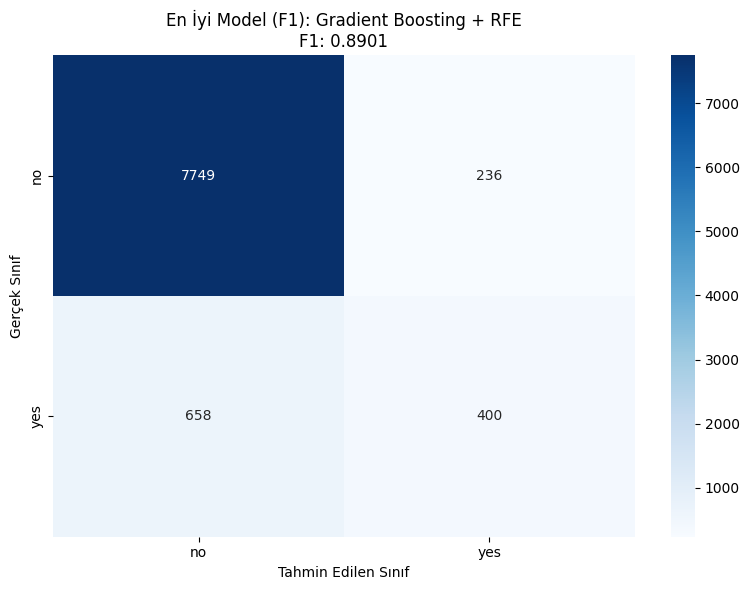

In [25]:
if best_model_name_f1:
        print(f"\nEn İyi F1-Skoru: {best_model_name_f1} algoritması {best_feature_set_f1} özellik seti ile")
        

        # En iyi modelin karışıklık matrisini görselleştirelim
        plt.figure(figsize=(8, 6))
        cm_best = results[(best_model_name_f1, best_feature_set_f1)]['confusion_matrix']
        sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f"En İyi Model (F1): {best_model_name_f1} + {best_feature_set_f1}\nF1: {best_f1:.4f}")
        plt.ylabel('Gerçek Sınıf')
        plt.xlabel('Tahmin Edilen Sınıf')
        plt.tight_layout()
        plt.show()